# Unbiased performance estimates for your classifiers

*This notebook first appeared as a [blog post](//betatim.github.io/posts/bumping) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2016, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

> This is an [interactive blog post](https://betatim.github.io/posts/really-interactive-posts/), you can modify and run the code directly from your browser. To
> see any of the output you have to run each of the cells.

In particle physics applications (like the [flavour of physics competition](https://www.kaggle.com/c/flavours-of-physics/) on kaggle) we often optimise
the decision threshold of the classifier used to select events.

Recently we discussed (once again) the question of how to optimise the
decision threshold in an unbiased way. So I decided to build a small
toy model to illustrate some points and make the discussion more concrete.

What happens if you optimise this parameter via cross-validation and use
the classifier performance estimated on each held-out subset as an estiamte
for the true performance?

If you studied up on ML, then you know the answer: it will most likely be
a optimistic estimate, not an unbiased one.

Below some examples of optimising hyper-parameters on a dataset where the
true performance is 0.5, aka there is no way to tell one class from the other.
This is convenient because by knowing the true performance, we can evaluate
whether or not our estimate is biased.

After optimising some standard hyper-parameters we will build two meta-estimators
that help with finding the best decision threshold via the normal `GridSearchCV`
interface.

To sweeten the deal, here a gif of Benedict Cumberbatch pretending to be unbiased:

<img src="http://i.gifntext.com/35465-neutral-indifferent-unbiased-neutral.gif" />

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, MetaEstimatorMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, KFold
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_random_state

## Uninformative data

This data set uses a mix of gaussian and uniformly distributed features and assigns
the class label purely at random. Therefore we know that the true accuracy of any
classifier on this sample is 0.5.

Conclude something from that Sherlock!

In [3]:
def data(N=1000, n_features=100, random_state=None):
    rng = check_random_state(random_state)
    gaussian_features = n_features//2

    return (np.hstack([rng.normal(size=(N, gaussian_features)),
                       rng.uniform(size=(N, n_features-gaussian_features))]),
            np.array(rng.uniform(size=N)>0.5, dtype=int))

In [4]:
X, y = data(2000, random_state=1)
# set aside data for final (unbiased)performance evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

## Hyper-paramters

To kick things of, let's estimate a bunch of hyper-parameters for a typical random forest
based model. We keep the testing data to the side for the moment and use only
the training set. `GridSearchCV` will evaluate the performance of the classifier
using three folds. 

In [5]:
param_grid = {'max_depth': [1, 2, 5, 10, 20, 30, 40, 50],
              'max_features': [4, 8, 16, 32, 64, 80, 100]}

rf = RandomForestClassifier(random_state=94)
grid = GridSearchCV(rf,
                    param_grid=param_grid,
                    n_jobs=6,
                    verbose=0)

In [6]:
_ = grid.fit(X_train, y_train)

The best parameters found and their score:

In [7]:
print("Best score: %.4f"%grid.best_score_)
print("Best params:", grid.best_params_)
print("Score on a totaly fresh dataset:", grid.score(X_test, y_test))

Best score: 0.5342
Best params: {'max_depth': 2, 'max_features': 80}
Score on a totaly fresh dataset: 0.50875


The best accuracy we found is around 0.67 with `max_depth=1` and `max_features=8`.
As we created the dataset with out any informative features we know that the true score
of any classifier is 0.5. Therefore this is either a fluctuation (because we don't measure
the score precisely enough) or the score from `GridSearchCV` is biased.

You can also see that usign a fresh, never seen before sample gives us an estimated
accuracy of 0.497.


## Bias or no bias?

To test this whether the accuracy obtained from `GridSearchCV` is biased or just a
fluke let's repeatedly grid-search for the best parameters and look
at the average score. For this we generate a brand new dataset each time. The joys
of having an infinite stream of data!

In [8]:
def grid_search(n, param_grid, clf=None):
    X, y = data(1200, random_state=0+n)
    if clf is None:
        clf = RandomForestClassifier(random_state=94+n)

    grid = GridSearchCV(clf,
                        param_grid=param_grid,
                        n_jobs=6,
                        verbose=0)
    grid.fit(X, y)
    return grid

scores = [grid_search(n, param_grid).best_score_ for n in range(40)]

Average score: 0.5292+-0.0015


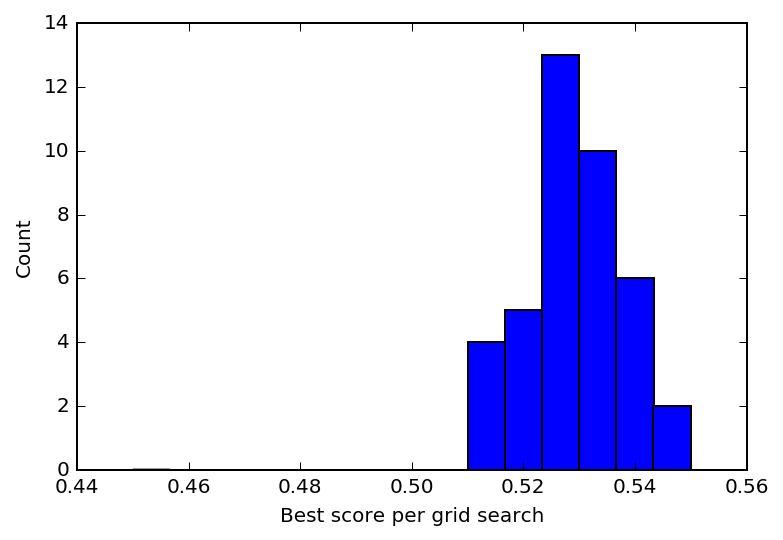

In [9]:
plt.hist(scores, range=(0.45,0.55), bins=15)
plt.xlabel("Best score per grid search")
plt.ylabel("Count")
print("Average score: %.4f+-%.4f" %(np.mean(scores), sp.stats.sem(scores)))

As you can see all of the best scores we find are above 0.5 and the average score
is close to 0.53, with a small uncertainty.

Conclusion: the best score obtained during grid search is not an unbiased
estimate of the true performance. Instead it is an optimistic estimate.

## Threshold optimisation

Next, let's see what happens if we use a different hyper-parameter: the threshold applied
to decide which class a sample falls in during prediction time.

For this to owrk in the `GridSearchCV` framework we construct two meta-estimators.

The first one is a transformer. It transforms the features of a sample into the
output of a classifier.

The second one is a very simple classifier, it assigns samples to one of two classes
based on a threshold.

Cmbining them in a pipeline we can then use `GridSearchCV` to optimise the threshold
as it if was any other hyper-parameter.

In [10]:
class PredictionTransformer(BaseEstimator, TransformerMixin, MetaEstimatorMixin):
    def __init__(self, clf):
        """Replaces all features with `clf.predict_proba(X)`"""
        self.clf = clf
    
    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
    
    def transform(self, X):
        return self.clf.predict_proba(X)


class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5):
        """Classify samples based on whether they are above of below `threshold`"""
        self.threshold = threshold

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        return self
    
    def predict(self, X):
        # the implementation used here breaks ties differently
        # from the one used in RFs:
        #return self.classes_.take(np.argmax(X, axis=1), axis=0)
        return np.where(X[:, 0]>self.threshold, *self.classes_)

With these two wrappers we can use `GridSearchCV` to find the 'optimal'
threshold. We use a different parameter grid that only varies the
classifier threshold. You can experiment with optimising all three
hyper-parameters in one go if you want to by uncommenting the `max_depth`
and `max_features` lines.

In [11]:
pipe = make_pipeline(PredictionTransformer(RandomForestClassifier()),
                     ThresholdClassifier())

pipe_param_grid = {#'predictiontransformer__clf__max_depth': [1, 2, 5, 10, 20, 30, 40, 50],
                   #'predictiontransformer__clf__max_features': [8, 16, 32, 64, 80, 100],
                   'thresholdclassifier__threshold': np.linspace(0, 1, num=100)}

grids = [grid_search(n,
                     clf=pipe,
                     param_grid=pipe_param_grid) for n in range(10)]
scores = [g.best_score_ for g in grids]
print("Average score: %.4f+-%.4f" %(np.mean(scores), sp.stats.sem(scores)))

Average score: 0.5275+-0.0017


As we expected the average score is larger than 0.5. This is why you should almost always
use a completely fresh dataset to estimate the performance of your classifier.

If you enjoyed this post, get in touch on twitter @[betatim](//twitter.com/betatim).